<a href="https://colab.research.google.com/github/AlexeyTri/MyMachineLearningSeminars/blob/main/seminar22/%D0%A0%D0%B5%D0%BA%D0%BE%D0%BC%D0%B5%D0%BD%D0%B4%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!!pip install --quiet -U  pyserini jsonlines scikit-surprise fastrank

[]

In [23]:
!!pip install multiprocess

['Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/',
 'Collecting multiprocess',
 '  Downloading multiprocess-0.70.14-py38-none-any.whl (132 kB)',
 '\x1b[?25l',
 '\x1b[K     |██▌                             | 10 kB 28.6 MB/s eta 0:00:01',
 '\x1b[K     |█████                           | 20 kB 36.3 MB/s eta 0:00:01',
 '\x1b[K     |███████▌                        | 30 kB 46.5 MB/s eta 0:00:01',
 '\x1b[K     |██████████                      | 40 kB 21.8 MB/s eta 0:00:01',
 '\x1b[K     |████████████▍                   | 51 kB 25.1 MB/s eta 0:00:01',
 '\x1b[K     |███████████████                 | 61 kB 28.5 MB/s eta 0:00:01',
 '\x1b[K     |█████████████████▍              | 71 kB 20.5 MB/s eta 0:00:01',
 '\x1b[K     |███████████████████▉            | 81 kB 21.5 MB/s eta 0:00:01',
 '\x1b[K     |██████████████████████▍         | 92 kB 23.4 MB/s eta 0:00:01',
 '\x1b[K     |████████████████████████▉       | 102 kB 20.6 MB/s eta 0:00:01',
 '\x1b[K

Библиотеки

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import gridspec
import multiprocess
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import scipy
import json
import re
import os
import jsonlines
import lightgbm as lgb
from multiprocess import Pool
from surprise import Dataset, Reader, SVD
from fastrank import CDataset, TrainRequest
from sklearn.datasets import load_svmlight_file
from functools import partial
# строка кода не работает
# from pyserini.search import SimpleSearcher

# Данные

In [5]:
data = Dataset.load_builtin('ml-100k')
trainset = data.build_full_trainset()
dataframe = pd.DataFrame(
    trainset.all_ratings(),
    columns=['uid', 'iid', 'rating'])
dataframe.sample(5, random_state=42)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


,uid,iid,rating
75721,688,145,1.0
80184,742,446,3.0
19864,116,113,5.0
76699,696,587,3.0
92991,877,325,3.0


In [8]:
uids = np.unique(dataframe['uid'].values)[:300]
means =  {uid: dataframe.loc[dataframe['uid'] == uid]['rating'].values.mean() for uid in uids}

In [9]:
mapping = dict()
for index in tqdm(dataframe.index):
    item = dataframe.loc[index]
    if item['uid'] in means:
        if item['uid'] not in mapping:
            mapping[item['uid']] = dict()
        mapping[item['uid']][item['iid']] = item['rating']

  0%|          | 0/100000 [00:00<?, ?it/s]

In [10]:
mapping_delta = dict()
for index in tqdm(dataframe.index):
    item = dataframe.loc[index]
    if item['uid'] in means:
        if item['uid'] not in mapping_delta:
            mapping_delta[item['uid']] = dict()
        mapping_delta[item['uid']][item['iid']] = item['rating'] - means[item['uid']]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [11]:
def r(uid, iid=None, delta=False):
    if uid not in mapping:
        return None
    
    mean = means[uid]
    if iid is None:
        if delta:
            all_iid = mapping_delta.get(uid, None)
            return [(key, all_iid[key]) for key in all_iid]
        else:
            all_iid = mapping.get(uid, None)
            return [(key, all_iid[key]) for key in all_iid]
    else:
        if delta:
            return mapping_delta.get(uid, None).get(iid, None)
        else:
            return mapping.get(uid, None).get(iid, None)

# Константная модель

In [12]:
def predict_user_constant(uid, iid):
    return means[uid]

In [13]:
%%time
predict_user_constant(1, 43)

CPU times: user 15 µs, sys: 1e+03 ns, total: 16 µs
Wall time: 21.7 µs


3.4130434782608696

In [14]:
r(1, 43)

3.0

# Корреляционная система

In [37]:
def predict_user_score(uid, iid, scores):
    weighted_score = 0
    list_of_ids = []

    pair_list = [(id, iid) for id in uids]
    f = lambda x: (x[0], x[1],r(*x, delta=True))

    for id, iid, r_id_iid_delta in Pool(processes=2).imap_unordered(f, pair_list):

        if id != uid:
            if r_id_iid_delta is not None:
                list_of_ids.append(id)
                weighted_score += scores[uid, id]*(r_id_iid_delta)

    if len(list_of_ids):
        return means[uid] + weighted_score/scores[uid, list_of_ids].sum()
    else:
        return None

In [19]:
def user_metric_one(u1, u2):
    r'''
    Оценка схожести объектов на основе квадрата разности средних оценок.

    :param u1: идентификатор первого пользователя
    :type u1: int
    :param u2: иденттификатор второго пользователя
    :type u2: int

    :return: оценку схожести объектов
    :rtype: float
    '''
    ru1 = means[u1]
    ru2 = means[u2]
    return np.exp(-1*(ru1 - ru2)**2)

In [25]:
scores = np.zeros(shape=[len(uids), len(uids)])

def f(pair):
    i, j = pair
    return i, j, user_metric_one(uids[i], uids[j])

pair_list = [(i, j) \
             for i in range(len(uids)) \
             for j in range(len(uids)) if i < j]

for i, j, score in tqdm(Pool(processes=2).imap_unordered(f, pair_list), total=len(pair_list)):
    scores[i, j] = score
    scores[j, i] = score

  0%|          | 0/44850 [00:00<?, ?it/s]

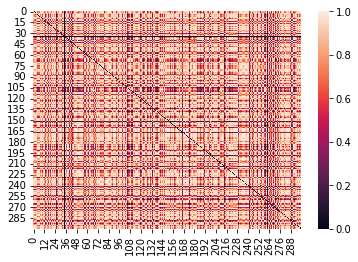

In [26]:
sns.heatmap(data=scores)
plt.show()

In [38]:
%%time
predict_user_score(1, 43, scores)

CPU times: user 280 ms, sys: 52.6 ms, total: 332 ms
Wall time: 374 ms


3.163324427315243

In [39]:
%%time
predict_user_constant(1, 43)

CPU times: user 17 µs, sys: 1e+03 ns, total: 18 µs
Wall time: 23.8 µs


3.4130434782608696

In [40]:
r(1, 43)

3.0

# SVD

In [41]:
algo = SVD()
algo = algo.fit(trainset)

In [42]:
algo.predict('1', '43').est

3.2296507320111676

Матричное представление пользователей

In [43]:
algo.pu.shape

(943, 100)

Матричное представление товаров

In [44]:
algo.qi.shape

(1682, 100)

Пример как предсказывается при помощи матричного разложения

In [45]:
algo.trainset.to_inner_iid('43'), algo.trainset.to_inner_uid('1')

(615, 118)

In [46]:
(algo.pu[118]*algo.qi[615]).sum() + algo.bu[118] + algo.bi[615] + algo.trainset.global_mean

3.229650732011168